# Poor Children Impact Analysis - Sigmoid/Interpolation Comparison

This notebook compares the sigmoid and two interpolation approaches to model the relationship between **Relative Wealth Index (RWI)** and **poverty rate**, constrained to match both:

1. **Target poor children count** per area classification (Rural, Urban, KMA)
2. **Quintile points** from the quintile method (weighted average RWI and poverty rate per quintile)


All methods enforce three critical constraints:

### 1. Boundary Conditions
- **RWI = -2 -> 100% poverty rate**: The poorest possible areas have 100% poverty
- **RWI = 2 -> 0% poverty rate**: The wealthiest possible areas have 0% poverty
- These boundaries ensure the function behaves reasonably at the extremes of the RWI distribution

### 2. Monotonic Decreasing
- **Poverty rate must decrease as RWI increases**: This ensures logical consistency - wealthier areas cannot have higher poverty rates than poorer areas
- **No increasing segments**: The function never increases for higher RWI values
- **No decreasing segments for lower RWI**: The function never decreases for lower RWI values

### 3. Smooth Curves
- **No sharp cuts or discontinuities**: The function should be smooth and continuous
- **No sudden drop-offs**: Gradual transitions between different RWI values


## Approaches Tested

1. **Sigmoid Function** 
   - Logistic curve with optimized parameters
   - Naturally monotonic decreasing
   - Smooth S-shaped curve

2. **Monotonic PCHIP** 
   - Piecewise Cubic Hermite Interpolating Polynomial
   - Preserves monotonicity of input data
   - Smooth interpolation that passes through all quintile points
   - Extrapolates smoothly beyond data range

3. **Akima Interpolation**
   - Smooth interpolation method
   - Less oscillatory than standard cubic splines


## Methodology

For each approach:

1. **Fit to quintile points**: Fit the function to the 5 quintile points (RWI, poverty_rate) for each region
2. **Add boundary conditions**: Ensure the function respects RWI = -2 -> 100% and RWI = 2 -> 0%
3. **Scale to match target**: Apply a scaling factor to match the target poor children count
4. **Verify monotonicity**: Check that the function remains monotonic decreasing after scaling
5. **Evaluate fit quality**: Calculate errors for both target matching and quintile point fitting

## Evaluation Metrics

- **Target Error**: Difference between achieved and target poor children count (absolute and percentage)
- **Quintile RMSE**: Root Mean Squared Error between predicted and actual poverty rates at quintile RWI values
- **Monotonicity Check**: Verification that the function is monotonic decreasing before and after scaling


## Configuration


In [1]:
# ============================================================================
# CONFIGURATION
# ============================================================================

# Base directory where downloaded files are located
BASE_DIR = "data"

# Country identifier
COUNTRY = "JAM"

# ============================================================================
# POVERTY RATES BY CLASSIFICATION
# ============================================================================

# Moderate poverty rates (%) for children (ages 0-15) by area classification 2022
POVERTY_RATE_RURAL = 34.6460305820465
POVERTY_RATE_URBAN = 22.9166205159144
POVERTY_RATE_KMA = 34.5674892972073  # Kingston Metropolitan Area (Kingston + Saint Andrew)

POVERTY_RATES = {
    "Rural": POVERTY_RATE_RURAL,
    "Urban": POVERTY_RATE_URBAN,
    "KMA": POVERTY_RATE_KMA
}

# SMOD classification threshold (>= 20 = urban, < 20 = rural)
SMOD_URBAN_THRESHOLD = 20.0

# Kingston Metropolitan Area parishes
KMA_PARISHES = ["Kingston", "Saint Andrew"]

print("# Poverty Rates by Classification (for children ages 0-15):")
print(f"  Rural: {POVERTY_RATE_RURAL:.2f}%")
print(f"  Urban: {POVERTY_RATE_URBAN:.2f}%")
print(f"  KMA (Kingston + Saint Andrew): {POVERTY_RATE_KMA:.2f}%")
print(f"\nSMOD Urban Threshold: >= {SMOD_URBAN_THRESHOLD}")
print(f"KMA Parishes: {', '.join(KMA_PARISHES)}")


# Poverty Rates by Classification (for children ages 0-15):
  Rural: 34.65%
  Urban: 22.92%
  KMA (Kingston + Saint Andrew): 34.57%

SMOD Urban Threshold: >= 20.0
KMA Parishes: Kingston, Saint Andrew


## Import Libraries


In [2]:
import os
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import optimize, interpolate
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
try:
    plt.style.use('seaborn-v0_8')
except:
    try:
        plt.style.use('seaborn')
    except:
        plt.style.use('default')
sns.set_palette("husl")

plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'

# ============================================================================
# VISUALIZATION SAVING SETUP
# ============================================================================
SAVE_VISUALIZATIONS = True
VISUALIZATIONS_DIR = "analysis_output/poor_children_impact_analysis_sig_opt_and_interpolation"

if SAVE_VISUALIZATIONS:
    os.makedirs(VISUALIZATIONS_DIR, exist_ok=True)
    print(f"Visualizations will be saved to: {VISUALIZATIONS_DIR}/")
else:
    print("Visualization saving is disabled (set SAVE_VISUALIZATIONS = True to enable)")

# plt.show() wrapper for auto-saving
_original_show = plt.show
_figure_counter = {'count': 0}

def _show_with_save(*args, **kwargs):
    """Wrapper around plt.show() that saves meaningful figures automatically"""
    if SAVE_VISUALIZATIONS:
        fig = plt.gcf()
        axes = fig.get_axes()
        
        filename = None
        
        if axes:
            try:
                if fig._suptitle is not None:
                    suptitle = fig._suptitle.get_text()
                    if suptitle and suptitle.strip():
                        filename = suptitle.lower().replace(' ', '_').replace('\n', '_')
                        filename = ''.join(c for c in filename if c.isalnum() or c in '_-')
            except:
                pass
            
            if not filename:
                for ax in axes:
                    try:
                        title = ax.get_title()
                        if title and title.strip():
                            filename = title.lower().replace(' ', '_').replace('\n', '_')
                            filename = ''.join(c for c in filename if c.isalnum() or c in '_-')
                            break
                    except:
                        pass
        
        if filename:
            _figure_counter['count'] += 1
            output_file = os.path.join(VISUALIZATIONS_DIR, f"{filename}_{_figure_counter['count']}.png")
            fig.savefig(output_file, dpi=300, bbox_inches='tight')
            print(f"  Saved: {output_file}")
    
    _original_show(*args, **kwargs)

plt.show = _show_with_save


Visualizations will be saved to: analysis_output/poor_children_impact_analysis_sig_opt_and_interpolation/


## Load Data


In [3]:
# Load pre-processed data
processed_file = "analysis_output/poor_children_impact_analysis_slope_opt/all_tiles_with_poor_children_flag.parquet"
if os.path.exists(processed_file):
    print("Loading pre-processed data...")
    gdf_tiles_with_admin = gpd.read_parquet(processed_file)
    if 'poverty_prob' in gdf_tiles_with_admin.columns:
        gdf_tiles_with_admin = gdf_tiles_with_admin.drop(columns=['poverty_prob'])
    print(f"Loaded {len(gdf_tiles_with_admin)} tiles")
else:
    raise FileNotFoundError("Please run the slope optimization notebook first to generate processed data")

# Load quintile points
quintile_rwi_file = "analysis_output/quintile_method/quintile_population_weighted_rwi_summary.csv"
df_quintile_rwi = pd.read_csv(quintile_rwi_file)

quintile_tiles_file = "analysis_output/quintile_method/tiles_with_quintile_poverty.parquet"
gdf_quintile_tiles = gpd.read_parquet(quintile_tiles_file)

# Get poverty rates per quintile per classification
quintile_poverty_rates = gdf_quintile_tiles.groupby(['area_classification', 'wealth_quintile']).agg({
    'poverty_prob': 'first'
}).reset_index()
quintile_poverty_rates.columns = ['classification', 'quintile', 'poverty_rate']

# Merge with RWI averages
df_quintile_points = df_quintile_rwi.merge(quintile_poverty_rates, 
                                            on=['classification', 'quintile'], 
                                            how='left')

print("\nQuintile Points Summary:")
for region in ['Rural', 'Urban', 'KMA']:
    region_data = df_quintile_points[df_quintile_points['classification'] == region]
    if len(region_data) > 0:
        print(f"\n{region}:")
        for _, row in region_data.sort_values('quintile').iterrows():
            q = int(row['quintile'])
            print(f"  Q{q}: RWI={row['weighted_avg_rwi']:.3f}, Poverty Rate={row['poverty_rate']}")


Loading pre-processed data...
Loaded 2224 tiles

Quintile Points Summary:

Rural:
  Q1: RWI=-0.281, Poverty Rate=0.6123951001957423
  Q2: RWI=0.026, Poverty Rate=0.32710384423039485
  Q3: RWI=0.245, Poverty Rate=0.2242650508265701
  Q4: RWI=0.441, Poverty Rate=0.18434075235155728
  Q5: RWI=0.785, Poverty Rate=0.11608698774569355

Urban:
  Q1: RWI=0.414, Poverty Rate=0.4307819617303414
  Q2: RWI=0.654, Poverty Rate=0.32746869548793806
  Q3: RWI=0.817, Poverty Rate=0.22668764811417494
  Q4: RWI=0.956, Poverty Rate=0.11981063303732835
  Q5: RWI=1.131, Poverty Rate=0.06623603508222804

KMA:
  Q1: RWI=0.425, Poverty Rate=0.7076172912580596
  Q2: RWI=0.824, Poverty Rate=0.48044750054168517
  Q3: RWI=0.998, Poverty Rate=0.33787232722163546
  Q4: RWI=1.190, Poverty Rate=0.17589608429936265
  Q5: RWI=1.471, Poverty Rate=0.10573253854992952


## Fitting Functions

- **Boundary conditions**: RWI = -2 → 100% poverty, RWI = 2 → 0% poverty
- **Monotonic decreasing**: Poverty rate decreases as RWI increases
- **Smooth curves**: No sharp cuts or strange drop-offs


In [4]:
# Boundary conditions
RWI_MIN = -2.0
RWI_MAX = 2.0
POVERTY_RATE_MIN = 0.0  # At RWI_MAX
POVERTY_RATE_MAX = 1.0  # At RWI_MIN

def add_boundary_points(rwi, poverty_rate):
    """
    Add boundary points: RWI=-2 -> 100%, RWI=2 -> 0%
    
    ALWAYS adds these boundary points to ensure all methods respect the boundary conditions.
    The data is sorted to ensure monotonic decreasing order.
    """
    # Ensure monotonic decreasing by sorting
    sort_idx = np.argsort(rwi)
    sorted_rwi = rwi[sort_idx]
    sorted_poverty = poverty_rate[sort_idx]
    
    # This ensures all methods respect the boundary conditions
    extended_rwi = np.concatenate([[RWI_MIN], sorted_rwi, [RWI_MAX]])
    extended_poverty = np.concatenate([[POVERTY_RATE_MAX], sorted_poverty, [POVERTY_RATE_MIN]])
    
    return extended_rwi, extended_poverty

### Sigmoid

In [5]:
def sigmoid(rwi, threshold, slope):
    """
    Sigmoid function - naturally monotonic decreasing.
    
    1 / (1 + exp(slope * (RWI - threshold)))
    - Higher slope = steeper transition
    - threshold = RWI value where poverty rate = 50%
    - Naturally bounded between 0 and 1
    """
    return 1.0 / (1.0 + np.exp(slope * (rwi - threshold)))


def fit_sigmoid(quintile_rwi, quintile_poverty):
    """
    Fit sigmoid to quintile points with boundary constraints
    
    1. Weighted fitting: Weight quintile points by importance (Q1 and Q5 weighted more)
    2. Initial guess: Use linear regression to estimate threshold
    3. Multiple optimization attempts: Try different initial guesses and methods
    4. Adaptive boundary penalty: Adjust penalty weight based on data range
    
    Strategy: Fit sigmoid to quintile points only (not boundary points),
    but add a soft penalty to encourage boundary compliance.
    """
    # Calculate weights: weight Q1 and Q5 more
    n_points = len(quintile_rwi)
    weights = np.ones(n_points)
    weights[0] = 2.0  # Q1 (poorest)
    weights[-1] = 2.0  # Q5 (wealthiest)
    weights = weights / weights.sum() * n_points  # Normalize so sum = n_points
    
    # Calculate data range to adjust boundary penalty
    rwi_range = quintile_rwi.max() - quintile_rwi.min()
    # If data is far from boundaries, use smaller penalty
    dist_to_boundary_min = abs(quintile_rwi.min() - RWI_MIN)
    dist_to_boundary_max = abs(quintile_rwi.max() - RWI_MAX)
    avg_boundary_dist = (dist_to_boundary_min + dist_to_boundary_max) / 2
    # Adaptive penalty: smaller when boundaries are far
    boundary_weight = 0.1 * min(1.0, rwi_range / avg_boundary_dist)
    
    def objective(params):
        threshold, slope = params
        predicted = sigmoid(quintile_rwi, threshold, slope)
        
        # Weighted error: prioritize quintile points, especially extremes
        quintile_error = np.sum(weights * (predicted - quintile_poverty) ** 2)
        
        # Boundary compliance penalty (adaptive weight)
        boundary_pred_min = sigmoid(RWI_MIN, threshold, slope)
        boundary_pred_max = sigmoid(RWI_MAX, threshold, slope)
        boundary_error = ((boundary_pred_min - POVERTY_RATE_MAX) ** 2 + 
                         (boundary_pred_max - POVERTY_RATE_MIN) ** 2)
        
        return quintile_error + boundary_weight * boundary_error
    
    # Better initial guess using linear regression
    # Transform poverty rate to logit space for linear fit
    # Avoid log(0) and log(1) by clipping
    eps = 1e-6
    poverty_clipped = np.clip(quintile_poverty, eps, 1 - eps)
    logit_poverty = np.log(poverty_clipped / (1 - poverty_clipped))
    
    # Linear fit: logit(poverty) ≈ slope * (RWI - threshold)
    # So: logit_poverty ≈ slope * RWI - slope * threshold
    # Therefore: threshold ≈ RWI - logit_poverty / slope
    # First estimate slope from linear regression
    if len(quintile_rwi) > 1:
        # Simple linear regression: logit_poverty = a * RWI + b
        # slope ≈ -a, threshold ≈ -b/a
        coeffs = np.polyfit(quintile_rwi, logit_poverty, 1)
        estimated_slope = abs(coeffs[0])  # Should be positive (decreasing)
        estimated_threshold = -coeffs[1] / coeffs[0] if coeffs[0] != 0 else np.median(quintile_rwi)
        # Clip to reasonable bounds
        estimated_threshold = np.clip(estimated_threshold, -2.0, 2.0)
        estimated_slope = np.clip(estimated_slope, 0.5, 8.0)
    else:
        estimated_threshold = np.median(quintile_rwi)
        estimated_slope = 2.0
    
    # Try multiple optimization strategies
    best_result = None
    best_error = np.inf
    
    # Strategy 1: Use estimated parameters
    initial_guesses = [
        [estimated_threshold, estimated_slope],
        [np.median(quintile_rwi), 2.0],
        [np.median(quintile_rwi), 1.0],
        [np.median(quintile_rwi), 4.0],
        [quintile_rwi[0], 2.0],  # Start at Q1
        [quintile_rwi[-1], 2.0],  # Start at Q5
    ]
    
    methods = ['L-BFGS-B', 'TNC', 'SLSQP']
    
    for x0 in initial_guesses:
        for method in methods:
            try:
                result = optimize.minimize(
                    objective,
                    x0=x0,
                    method=method,
                    bounds=[(-2.0, 2.0), (0.1, 10.0)],
                    options={'maxiter': 1000, 'ftol': 1e-9}
                )
                if result.success:
                    error = objective(result.x)
                    if error < best_error:
                        best_error = error
                        best_result = result
            except:
                continue
    
    # Fallback to simple L-BFGS-B if all failed
    if best_result is None:
        best_result = optimize.minimize(
            objective,
            x0=[estimated_threshold, estimated_slope],
            method='L-BFGS-B',
            bounds=[(-2.0, 2.0), (0.1, 10.0)]
        )
    
    return {'threshold': best_result.x[0], 'slope': best_result.x[1]}

def predict_sigmoid(rwi, params):
    """Predict using sigmoid - naturally monotonic"""
    predicted = sigmoid(rwi, params['threshold'], params['slope'])
    # Clip to [0, 1] and ensure boundary conditions
    predicted = np.clip(predicted, 0, 1)
    # Only enforce boundaries at exact boundary values to avoid plateaus
    # For sigmoid, it should naturally approach boundaries smoothly
    boundary_mask_min = rwi <= RWI_MIN
    boundary_mask_max = rwi >= RWI_MAX
    predicted[boundary_mask_min] = POVERTY_RATE_MAX
    predicted[boundary_mask_max] = POVERTY_RATE_MIN
    return predicted

### Monotonic PCHIP

In [6]:
def fit_monotonic_pchip(quintile_rwi, quintile_poverty):
    """
    Fit monotonic PCHIP to quintile points with boundary conditions.
    """
    # Add boundary points to the fit
    extended_rwi, extended_poverty = add_boundary_points(quintile_rwi, quintile_poverty)
    
    # PCHIP automatically preserves monotonicity
    pchip = interpolate.PchipInterpolator(extended_rwi, extended_poverty)
    return {'pchip': pchip}

def predict_monotonic_pchip(rwi, params):
    """
    Predict using monotonic PCHIP interpolation.
    
    PCHIP interpolates smoothly within the fitted range and we enforce
    boundary conditions for values outside the range.
    """
    pchip = params['pchip']
    predicted = np.zeros_like(rwi)
    
    # Get the interpolation range from the fitted points
    rwi_min_fitted = pchip.x[0]  # Should be RWI_MIN
    rwi_max_fitted = pchip.x[-1]  # Should be RWI_MAX
    
    # Below minimum: enforce boundary condition (100% poverty)
    below_min = rwi < rwi_min_fitted
    predicted[below_min] = POVERTY_RATE_MAX
    
    # Above maximum: enforce boundary condition (0% poverty)
    above_max = rwi > rwi_max_fitted
    predicted[above_max] = POVERTY_RATE_MIN
    
    # Within interpolation range: use PCHIP
    in_range = ~(below_min | above_max)
    if np.any(in_range):
        predicted[in_range] = pchip(rwi[in_range])
    
    # Ensure values stay in valid range [0, 1]
    predicted = np.clip(predicted, 0, 1)
    
    # Strictly enforce boundary conditions
    predicted[rwi <= RWI_MIN] = POVERTY_RATE_MAX
    predicted[rwi >= RWI_MAX] = POVERTY_RATE_MIN
    
    return predicted

### Monotonic interpolation with Akima

In [7]:
def fit_akima(quintile_rwi, quintile_poverty):
    """
    Fit Akima interpolation with boundary conditions.
    
    Akima interpolation is smooth and less oscillatory than standard cubic splines.
    """
    # Add boundary points to the fit
    extended_rwi, extended_poverty = add_boundary_points(quintile_rwi, quintile_poverty)
    
    # Akima interpolation
    akima = interpolate.Akima1DInterpolator(extended_rwi, extended_poverty)
    return {'akima': akima}

def predict_akima(rwi, params):
    """
    Predict using Akima interpolation.
    
    Handles extrapolation by enforcing boundary conditions.
    Since boundary points are included in the fit, interpolation should cover the range.
    """
    akima = params['akima']
    predicted = np.zeros_like(rwi)
    
    # Get the interpolation range from the fitted points
    rwi_min_fitted = akima.x[0]  # Should be RWI_MIN
    rwi_max_fitted = akima.x[-1]  # Should be RWI_MAX
    
    # Below minimum: enforce boundary condition (100% poverty)
    below_min = rwi < rwi_min_fitted
    predicted[below_min] = POVERTY_RATE_MAX
    
    # Above maximum: enforce boundary condition (0% poverty)
    above_max = rwi > rwi_max_fitted
    predicted[above_max] = POVERTY_RATE_MIN
    
    # Within interpolation range: use Akima
    in_range = ~(below_min | above_max)
    if np.any(in_range):
        predicted[in_range] = akima(rwi[in_range])
    
    # Ensure values stay in valid range [0, 1]
    predicted = np.clip(predicted, 0, 1)
    
    # Strictly enforce boundary conditions
    predicted[rwi <= RWI_MIN] = POVERTY_RATE_MAX
    predicted[rwi >= RWI_MAX] = POVERTY_RATE_MIN
    
    return predicted

In [8]:
FITTING_METHODS = {
    'Sigmoid': {
        'fit': fit_sigmoid,
        'predict': predict_sigmoid,
    },
    'Monotonic PCHIP': {
        'fit': fit_monotonic_pchip,
        'predict': predict_monotonic_pchip,
    },
    'Akima Interpolation': {
        'fit': fit_akima,
        'predict': predict_akima,
    }
}

## Fit and Scale Functions

Fits each method (regression or interpolation) to quintile points (with boundary conditions), then scales the predictions to match the target poor children count.

### Scaling Process

The scaling process works as follows:

1. **Fit function to quintile points**: Each method fits a curve through the 5 quintile points (plus boundary points)
2. **Calculate base predictions**: Predict poverty rates for all tiles in the region
3. **Calculate current total**: Sum of (predicted_rate x children_population) for all tiles
4. **Calculate scale factor**: `scale_factor = target_poor_children / current_total`
5. **Apply scaling**: Multiply all predictions by the scale factor
6. **Clip to valid range**: Ensure all predictions stay within [0, 1]

### Monotonicity Verification
Verify monotonicity both before and after scaling:
- **Before scaling**: Check that the fitted function is monotonic decreasing
- **After scaling**: Verify that scaling didn't break monotonicity.


In [9]:
def verify_monotonicity(rwi, poverty_rate):
    """
    Verify that poverty rate is monotonic decreasing with RWI.
    RWI_i < RWI_j implies poverty_rate_i >= poverty_rate_j
    Check this by sorting by RWI and verifying all differences are <= 0
    """
    # Sort by RWI to check monotonicity
    sort_idx = np.argsort(rwi)
    sorted_rwi = rwi[sort_idx]
    sorted_poverty = poverty_rate[sort_idx]
    
    # Check if decreasing (all differences should be <= 0)
    diffs = np.diff(sorted_poverty)
    is_monotonic = np.all(diffs <= 1e-10)  # Allow small numerical errors
    
    return is_monotonic, np.max(diffs) if len(diffs) > 0 else 0

def scale_to_match_target(predict_func, params, df_region, target_poor_children):
    """
    Scale the predicted poverty rates to match target poor children count.
    Uses a scaling factor applied to all predictions.
    Preserves monotonicity (scaling by constant preserves monotonicity).
    """
    rwi_values = df_region['rwi'].values
    pop_values = df_region['children_population'].values
    
    # Get base predictions
    base_predictions = predict_func(rwi_values, params)
    
    # Verify monotonicity before scaling
    is_mono_before, max_diff_before = verify_monotonicity(rwi_values, base_predictions)
    
    # Calculate current total poor children
    current_total = np.sum(base_predictions * pop_values)
    
    if current_total == 0:
        # If all predictions are 0, use uniform scaling
        scale_factor = target_poor_children / np.sum(pop_values)
    else:
        # Scale factor to match target
        scale_factor = target_poor_children / current_total
    
    # Apply scaling (but keep in [0, 1])
    scaled_predictions = np.clip(base_predictions * scale_factor, 0, 1)
    
    # Verify monotonicity after scaling
    is_mono_after, max_diff_after = verify_monotonicity(rwi_values, scaled_predictions)
    
    return scaled_predictions, scale_factor, is_mono_before, is_mono_after

# Fit all methods for each region
poverty_rate_map = {
    'Rural': POVERTY_RATE_RURAL / 100,
    'Urban': POVERTY_RATE_URBAN / 100,
    'KMA': POVERTY_RATE_KMA / 100
}

all_results = {}

for region in ['Rural', 'Urban', 'KMA']:
    print(f"\n{'='*80}")
    print(f"Region: {region}")
    print(f"{'='*80}")
    
    # Filter region data
    mask = gdf_tiles_with_admin['area_classification'] == region
    df_region = gdf_tiles_with_admin[mask].copy()
    
    if len(df_region) == 0:
        continue
    
    # Calculate target
    total_pop = df_region['children_population'].sum()
    target_poor = total_pop * poverty_rate_map[region]
    
    # Get quintile points
    region_quintile_points = df_quintile_points[df_quintile_points['classification'] == region].copy()
    region_quintile_points = region_quintile_points.sort_values('quintile')
    
    quintile_rwi = region_quintile_points['weighted_avg_rwi'].values
    quintile_poverty = region_quintile_points['poverty_rate'].values
    
    region_results = {}

    # Try each method
    for method_name, method_funcs in FITTING_METHODS.items():
        try:
            # Fit to quintile points
            fit_params = method_funcs['fit'](quintile_rwi, quintile_poverty)
            
            # Scale to match target
            scaled_predictions, scale_factor, mono_before, mono_after = scale_to_match_target(
                method_funcs['predict'],
                fit_params,
                df_region,
                target_poor
            )
            
            # Calculate errors
            achieved_poor = np.sum(scaled_predictions * df_region['children_population'].values)
            children_error = abs(achieved_poor - target_poor)
            children_error_pct = (children_error / target_poor * 100) if target_poor > 0 else 0
            
            # Quintile fit error (on original scale, before scaling)
            quintile_predictions = method_funcs['predict'](quintile_rwi, fit_params)
            quintile_error = np.sum((quintile_predictions - quintile_poverty) ** 2)
            quintile_rmse = np.sqrt(np.mean((quintile_predictions - quintile_poverty) ** 2))
            
            # Store quintile predictions for debugging
            quintile_predictions_dict = {q: (rwi, pred, actual) for q, rwi, pred, actual in 
                                        zip(region_quintile_points['quintile'].values,
                                            quintile_rwi, quintile_predictions, quintile_poverty)}
            
            # Calculate base total before scaling (for diagnostics)
            base_predictions_for_diag = method_funcs['predict'](df_region['rwi'].values, fit_params)
            base_total = np.sum(base_predictions_for_diag * df_region['children_population'].values)
            
            region_results[method_name] = {
                'params': fit_params,
                'predictions': scaled_predictions,
                'scale_factor': scale_factor,
                'target_poor_children': target_poor,
                'achieved_poor_children': achieved_poor,
                'children_error': children_error,
                'children_error_pct': children_error_pct,
                'quintile_error': quintile_error,
                'quintile_rmse': quintile_rmse,
                'monotonic_before': mono_before,
                'monotonic_after': mono_after,
                'predict_func': method_funcs['predict']
            }
            
            print(f"\n{method_name}:")
            print(f"  Target: {target_poor:,.0f}, Achieved: {achieved_poor:,.0f}")
            print(f"  Error: {children_error:.2f} ({children_error_pct:.4f}%)")
            print(f"  Quintile RMSE: {quintile_rmse:.6f}")
            print(f"  Scale factor: {scale_factor:.4f}")
            print(f"  Monotonic: Before={mono_before}, After={mono_after}")
            print(f"    Quintile fit details:")
            for q in sorted(quintile_predictions_dict.keys()):
                rwi_q, pred_q, actual_q = quintile_predictions_dict[q]
                error_q = abs(pred_q - actual_q)
                print(f"      Q{q}: RWI={rwi_q:.3f}, Predicted={pred_q:.3f}, Actual={actual_q:.3f}, Error={error_q:.3f}")
            
        except Exception as e:
            print(f"\n{method_name}: FAILED - {str(e)}")
            continue
    
    all_results[region] = region_results



Region: Rural

Sigmoid:
  Target: 142,572, Achieved: 142,565
  Error: 6.45 (0.0045%)
  Quintile RMSE: 0.037075
  Scale factor: 1.1738
  Monotonic: Before=True, After=True
    Quintile fit details:
      Q1: RWI=-0.281, Predicted=0.587, Actual=0.612, Error=0.025
      Q2: RWI=0.026, Predicted=0.384, Actual=0.327, Error=0.057
      Q3: RWI=0.245, Predicted=0.257, Actual=0.224, Error=0.033
      Q4: RWI=0.441, Predicted=0.170, Actual=0.184, Error=0.014
      Q5: RWI=0.785, Predicted=0.075, Actual=0.116, Error=0.041

Monotonic PCHIP:
  Target: 142,572, Achieved: 142,569
  Error: 2.70 (0.0019%)
  Quintile RMSE: 0.000000
  Scale factor: 1.2037
  Monotonic: Before=True, After=True
    Quintile fit details:
      Q1: RWI=-0.281, Predicted=0.612, Actual=0.612, Error=0.000
      Q2: RWI=0.026, Predicted=0.327, Actual=0.327, Error=0.000
      Q3: RWI=0.245, Predicted=0.224, Actual=0.224, Error=0.000
      Q4: RWI=0.441, Predicted=0.184, Actual=0.184, Error=0.000
      Q5: RWI=0.785, Predicted=0.

## Visualize results

  Saved: analysis_output/poor_children_impact_analysis_sig_opt_and_interpolation/rural_comparison_of_fitting_methods_1.png


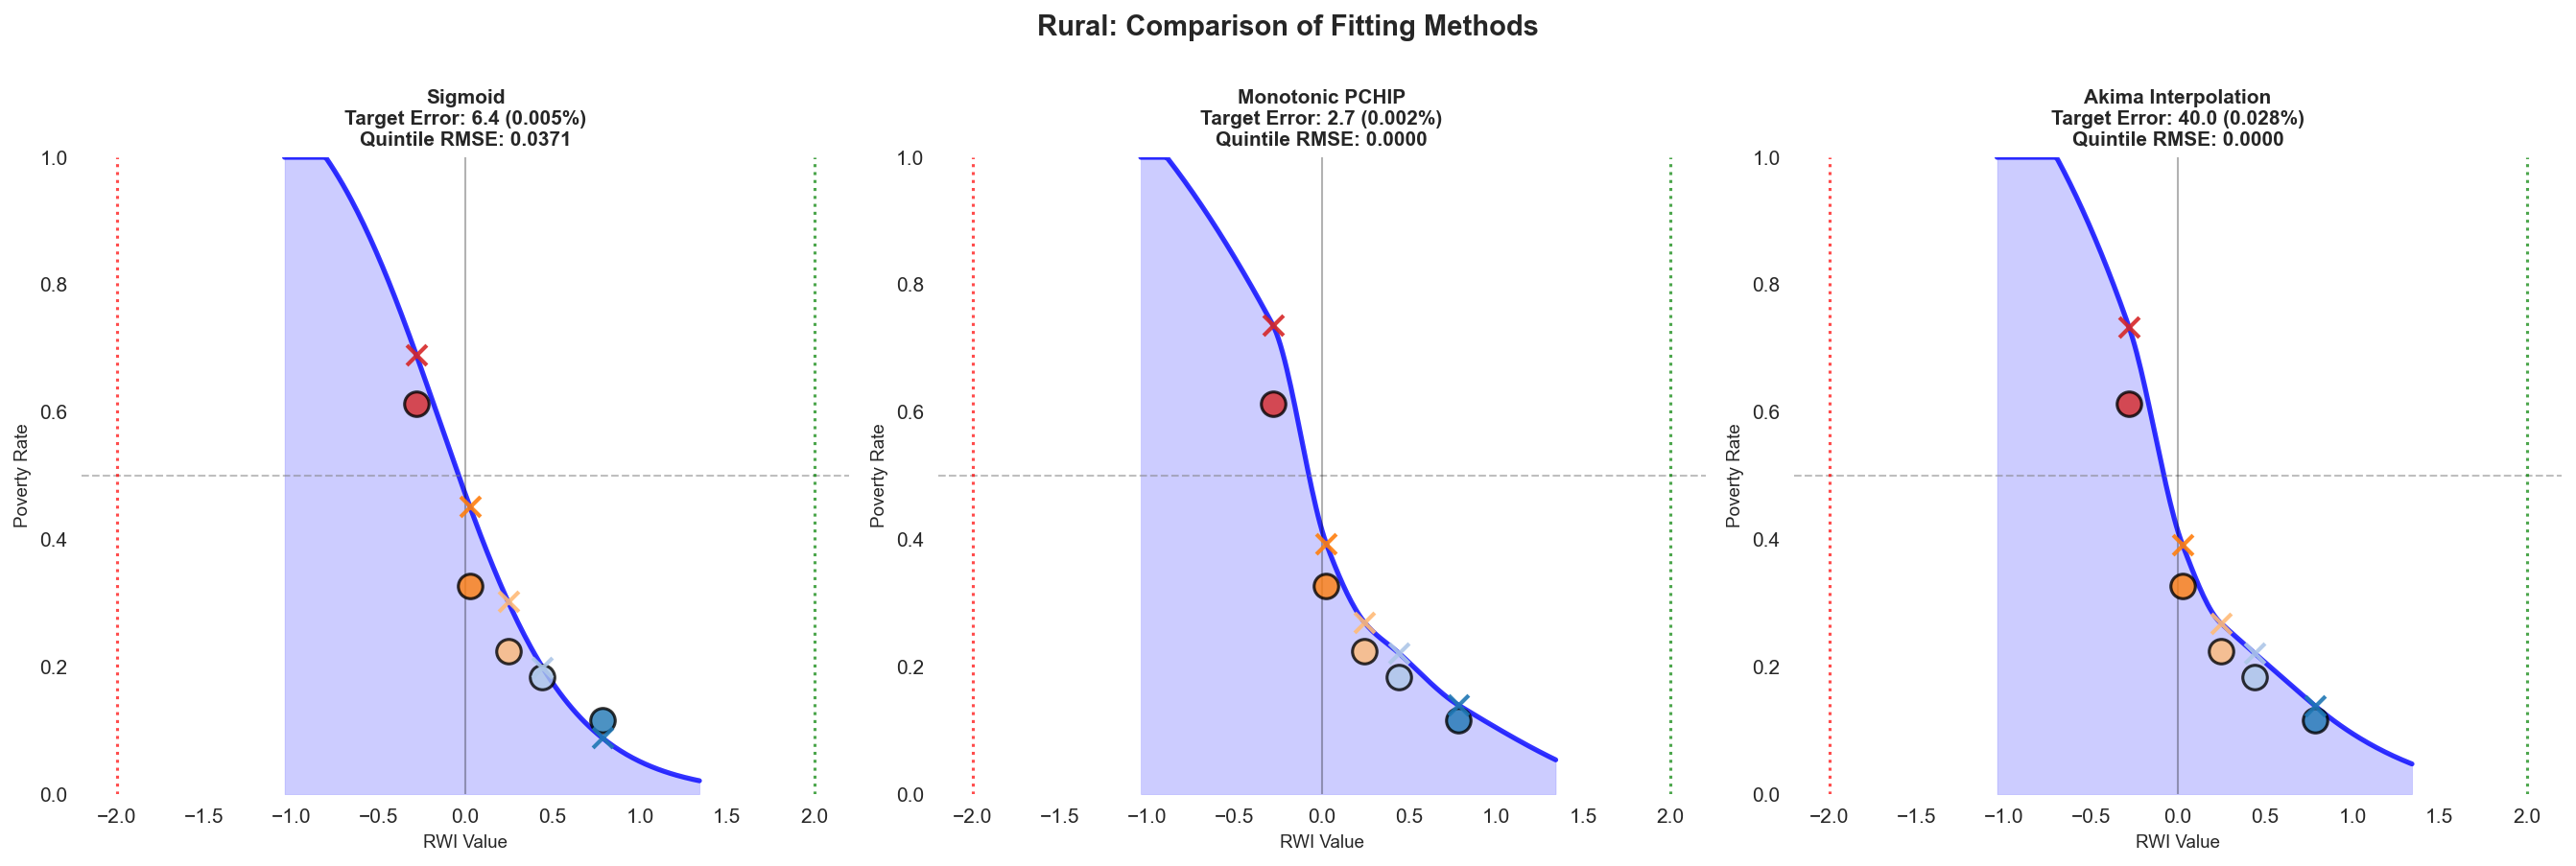

  Saved: analysis_output/poor_children_impact_analysis_sig_opt_and_interpolation/urban_comparison_of_fitting_methods_2.png


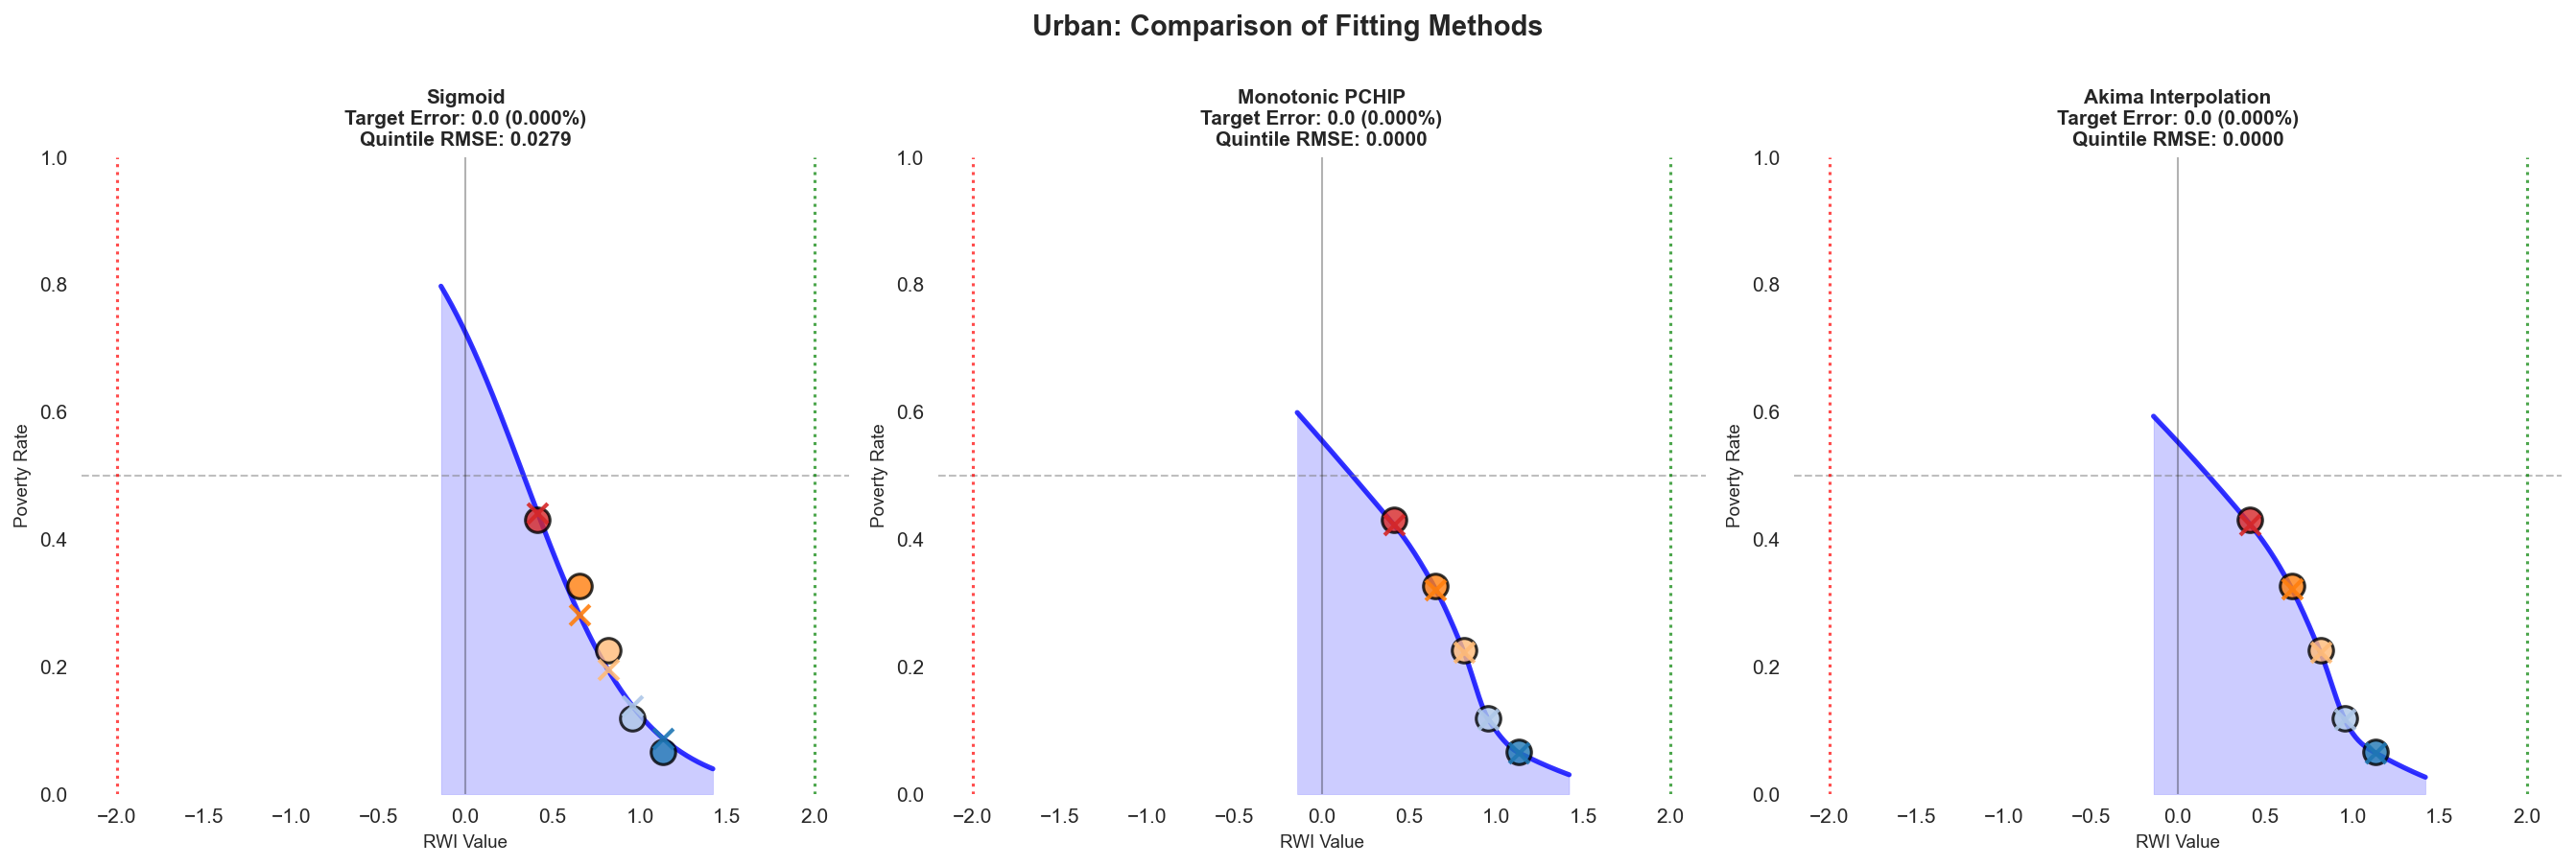

  Saved: analysis_output/poor_children_impact_analysis_sig_opt_and_interpolation/kma_comparison_of_fitting_methods_3.png


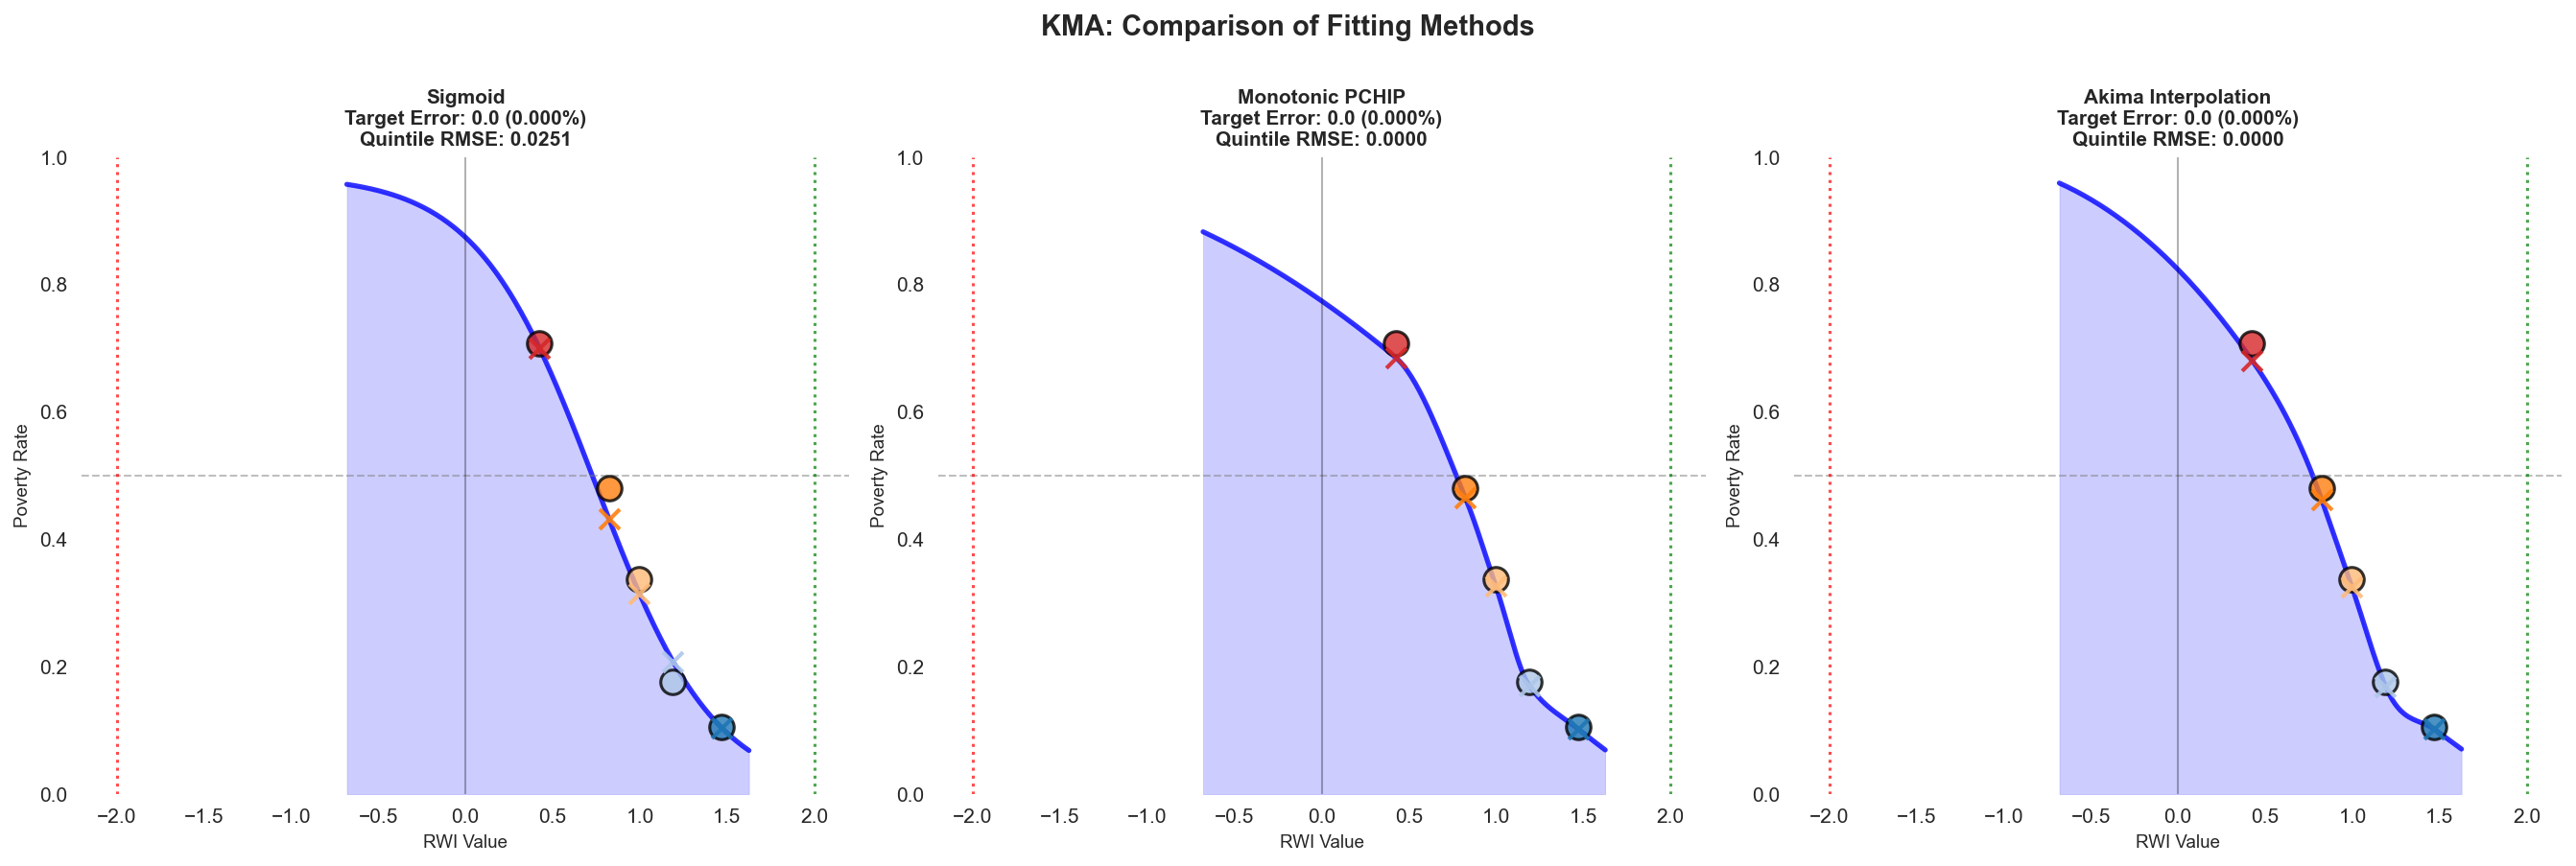

In [10]:
# Color scheme for quintiles
quintile_colors = {
    1: '#d62728',  # Red - Poorest
    2: '#ff7f0e',  # Orange
    3: '#ffbb78',  # Light Orange
    4: '#aec7e8',  # Light Blue
    5: '#1f77b4'   # Blue - Richest
}

# Plot all methods for each region
for region in ['Rural', 'Urban', 'KMA']:
    if region not in all_results:
        continue
    
    region_results = all_results[region]
    mask = gdf_tiles_with_admin['area_classification'] == region
    df_region = gdf_tiles_with_admin[mask].copy()
    
    # Get quintile points
    region_quintile_points = df_quintile_points[df_quintile_points['classification'] == region]
    
    # Create subplots - 2 rows, 3 columns
    n_methods = len(region_results)
    n_cols = 3
    n_rows = (n_methods + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 6*n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    axes = axes.flatten()
    
    # Extend RWI range to show boundary conditions
    rwi_min_plot = max(df_region['rwi'].min(), RWI_MIN - 0.2)
    rwi_max_plot = min(df_region['rwi'].max(), RWI_MAX + 0.2)
    rwi_range = np.linspace(rwi_min_plot, rwi_max_plot, 200)
    
    for idx, (method_name, result) in enumerate(region_results.items()):
        ax = axes[idx]
        
        # Get predictions for the full RWI range (before scaling)
        base_predictions = result['predict_func'](rwi_range, result['params'])
        
        # Apply scaling
        scale_factor = result['scale_factor']
        scaled_predictions = np.clip(base_predictions * scale_factor, 0, 1)
        
        # Plot curve
        ax.plot(rwi_range, scaled_predictions, 'b-', linewidth=2.5, 
                label=f'{method_name}', alpha=0.8)
        ax.fill_between(rwi_range, 0, scaled_predictions, alpha=0.2, color='blue')
        
        # Plot quintile points
        for _, row in region_quintile_points.iterrows():
            q = int(row['quintile'])
            rwi_avg = row['weighted_avg_rwi']
            poverty_rate = row['poverty_rate']
            
            if pd.notna(rwi_avg) and pd.notna(poverty_rate):
                # Actual quintile point
                ax.scatter(rwi_avg, poverty_rate, 
                          s=150, marker='o', 
                          color=quintile_colors[q], 
                          edgecolor='black', linewidth=1.5,
                          zorder=5, alpha=0.8)
                
                # Predicted value
                predicted_rate = result['predict_func'](np.array([rwi_avg]), result['params'])[0]
                predicted_rate_scaled = np.clip(predicted_rate * scale_factor, 0, 1)
                ax.scatter(rwi_avg, predicted_rate_scaled,
                          s=100, marker='x', 
                          color=quintile_colors[q],
                          linewidth=2, zorder=6, alpha=0.9)
        
        # Add reference lines
        ax.axhline(y=0.5, color='gray', linestyle='--', linewidth=1, alpha=0.5)
        ax.axvline(x=0, color='black', linestyle='-', linewidth=1, alpha=0.3)
        ax.axvline(x=RWI_MIN, color='red', linestyle=':', linewidth=1.5, alpha=0.7, label='Boundary: RWI=-2')
        ax.axvline(x=RWI_MAX, color='green', linestyle=':', linewidth=1.5, alpha=0.7, label='Boundary: RWI=2')
        
        # Title with metrics
        ax.set_title(f'{method_name}\n'
                     f'Target Error: {result["children_error"]:.1f} ({result["children_error_pct"]:.3f}%)\n'
                     f'Quintile RMSE: {result["quintile_rmse"]:.4f}',
                     fontsize=10, fontweight='bold')
        ax.set_xlabel('RWI Value', fontsize=9)
        ax.set_ylabel('Poverty Rate', fontsize=9)
        ax.set_ylim([0, 1])
        ax.grid(True, alpha=0.3)
    
    # Hide unused subplots
    for idx in range(len(region_results), len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle(f'{region}: Comparison of Fitting Methods',
                 fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout(rect=[0, 0, 1, 0.99])
    plt.show()

## Comparison Table

- **Target_Error**: Absolute difference between achieved and target poor children count
- **Target_Error_Pct**: Percentage error (Target_Error / Target x 100%)
- **Quintile_RMSE**: Root Mean Squared Error between predicted and actual poverty rates at quintile points
- **Scale_Factor**: The scaling factor applied to match the target (1.0 = no scaling needed)

### Best Method Selection

The best method for each region is selected based on a combined score:
- Normalized Target Error Percentage + Normalized Quintile RMSE
- Lower combined score = better overall performance


In [11]:
# Create summary comparison table
summary_data = []

for region in ['Rural', 'Urban', 'KMA']:
    if region not in all_results:
        continue
    
    region_results = all_results[region]
    for method_name, result in region_results.items():
        summary_data.append({
            'Region': region,
            'Method': method_name,
            'Target_Error': result['children_error'],
            'Target_Error_Pct': result['children_error_pct'],
            'Quintile_RMSE': result['quintile_rmse'],
            'Scale_Factor': result['scale_factor']
        })

df_summary = pd.DataFrame(summary_data)

print("\n" + "="*100)
print("Summary Comparison Table")
print("="*100)
print(df_summary.to_string(index=False))

# Find best method for each region based on combined score
print("\n" + "="*100)
print("Best Method per Region (based on combined score: Target Error % + Quintile RMSE)")
print("="*100)

for region in ['Rural', 'Urban', 'KMA']:
    if region not in all_results:
        continue
    
    region_data = df_summary[df_summary['Region'] == region].copy()
    if len(region_data) == 0:
        continue
    
    # Combined score (normalized)
    region_data['Combined_Score'] = (
        region_data['Target_Error_Pct'] / region_data['Target_Error_Pct'].max() +
        region_data['Quintile_RMSE'] / region_data['Quintile_RMSE'].max()
    )
    
    best_method = region_data.loc[region_data['Combined_Score'].idxmin()]
    
    print(f"\n{region}:")
    print(f"  Best Method: {best_method['Method']}")
    print(f"  Target Error: {best_method['Target_Error']:.2f} ({best_method['Target_Error_Pct']:.4f}%)")
    print(f"  Quintile RMSE: {best_method['Quintile_RMSE']:.6f}")
    print(f"  Combined Score: {best_method['Combined_Score']:.4f}")



Summary Comparison Table
Region              Method  Target_Error  Target_Error_Pct  Quintile_RMSE  Scale_Factor
 Rural             Sigmoid  6.446728e+00      4.521737e-03       0.037075      1.173808
 Rural     Monotonic PCHIP  2.697809e+00      1.892244e-03       0.000000      1.203699
 Rural Akima Interpolation  3.999899e+01      2.805531e-02       0.000000      1.197986
 Urban             Sigmoid  7.275958e-12      1.278072e-14       0.027946      0.991755
 Urban     Monotonic PCHIP  7.275958e-12      1.278072e-14       0.000000      0.981821
 Urban Akima Interpolation  7.275958e-12      1.278072e-14       0.000000      0.982942
   KMA             Sigmoid  7.275958e-12      1.132341e-14       0.025061      0.972022
   KMA     Monotonic PCHIP  2.182787e-11      3.397024e-14       0.000000      0.968681
   KMA Akima Interpolation  1.455192e-11      2.264683e-14       0.000000      0.962691

Best Method per Region (based on combined score: Target Error % + Quintile RMSE)

Rural:
  Be

## Save Results

In [12]:
output_dir = "analysis_output/poor_children_impact_analysis_sig_opt_and_interpolation"
os.makedirs(output_dir, exist_ok=True)

# Export Method Comparison Summary Table
# ----------------------------------------------------------------------------
# CSV file containing performance metrics for all methods across all regions
# Columns: Region, Method, Target_Error, Target_Error_Pct, Quintile_RMSE, Scale_Factor
# Used to compare how well each method (Sigmoid, PCHIP, Akima) performs
summary_file = os.path.join(output_dir, "method_comparison_summary.csv")
df_summary.to_csv(summary_file, index=False)
print(f"Exported method comparison summary to: {summary_file}")

# Export All Methods' Predictions per Region (with Best Method Flag)
# ----------------------------------------------------------------------------
# For each region (Rural, Urban, KMA), export all tiles with poverty probabilities
# from ALL methods (Sigmoid, PCHIP, Akima), and flag which method is best
# Files: {region}_all_methods.parquet
# Contains: 
#   - All tile geometries
#   - poverty_prob_sigmoid: Predictions from sigmoid method
#   - poverty_prob_pchip: Predictions from PCHIP method
#   - poverty_prob_akima: Predictions from Akima method
#   - poverty_prob_best: Predictions from best method (for convenience)
#   - best_method: Name of the best method for this region
#   - is_best_method: Boolean flag (True for best method column)

best_methods = {}
for region in ['Rural', 'Urban', 'KMA']:
    if region not in all_results:
        continue

    region_data = df_summary[df_summary['Region'] == region].copy()
    if len(region_data) == 0:
        continue

    # Calculate combined score to select best method
    region_data['Combined_Score'] = (
        region_data['Target_Error_Pct'] / region_data['Target_Error_Pct'].max() +
        region_data['Quintile_RMSE'] / region_data['Quintile_RMSE'].max()
    )

    best_method_name = region_data.loc[region_data['Combined_Score'].idxmin(), 'Method']
    best_methods[region] = best_method_name

    # Get tiles for this region
    mask = gdf_tiles_with_admin['area_classification'] == region
    gdf_region = gdf_tiles_with_admin[mask].copy()
    
    # Add predictions from all methods
    region_results = all_results[region]
    for method_name in region_results.keys():
        # Create clean column name (lowercase, replace spaces with underscores)
        col_name = f"poverty_prob_{method_name.lower().replace(' ', '_')}"
        gdf_region[col_name] = region_results[method_name]['predictions']
    
    # Add best method predictions and flag
    best_col_name = f"poverty_prob_{best_method_name.lower().replace(' ', '_')}"
    gdf_region['poverty_prob_best'] = gdf_region[best_col_name]
    gdf_region['best_method'] = best_method_name
    
    # Add boolean flag for each method indicating if it's the best
    for method_name in region_results.keys():
        col_name = f"poverty_prob_{method_name.lower().replace(' ', '_')}"
        flag_col = f"is_best_{method_name.lower().replace(' ', '_')}"
        gdf_region[flag_col] = (method_name == best_method_name)

    # Export tiles with all methods' predictions
    output_file = os.path.join(output_dir, f"{region.lower()}_all_methods.parquet")
    gdf_region.to_parquet(output_file, index=False)
    print(f"Exported {region} tiles with all methods (best: {best_method_name}) to: {output_file}")


Exported method comparison summary to: analysis_output/poor_children_impact_analysis_sig_opt_and_interpolation/method_comparison_summary.csv
Exported Rural tiles with all methods (best: Monotonic PCHIP) to: analysis_output/poor_children_impact_analysis_sig_opt_and_interpolation/rural_all_methods.parquet
Exported Urban tiles with all methods (best: Monotonic PCHIP) to: analysis_output/poor_children_impact_analysis_sig_opt_and_interpolation/urban_all_methods.parquet
Exported KMA tiles with all methods (best: Akima Interpolation) to: analysis_output/poor_children_impact_analysis_sig_opt_and_interpolation/kma_all_methods.parquet
